# Traffic Light Detection with Transfer Learning
In this notebook, we learn how to use [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to fine-tune a pretrained model on our own dataset/labels (our dataset can be small). We discuss the following points

* create our own traffic light dataset: images and annotations
* ensemble our dataset into TFRecord format
* use [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to fine-tune a pretrained model

## Traffic Light Dataset
We can extract traffic light images from ROS (simulator) using the following command
```
rosrun image_view image_saver image:=/image_color
```
or from ROS-bag by starting 3 terminals
```
# terminal 1 - run a master
roscore

# terminal 2 - play the bag file
rosbag play -l PATH_TO_BAG_FILE

# terminal 3 - collect images
rosrun image_view image_saver image:=/img_topic
```

To create annotated data one can use [labelImg](https://github.com/tzutalin/labelImg), to save time we re-use annotated data from this [repository](https://github.com/coldKnight/TrafficLight_Detection-TensorFlowAPI) or directly from [here](https://drive.google.com/file/d/0B-Eiyn-CUQtxdUZWMkFfQzdObUE/view?usp=sharing).

The data has the following structure

![dataset_structure](../media/dataset_structure.png)

The annotations are stored in `real_data_annotations.yaml` and `sim_data_annotations.yaml`. 

Let's visualize one example

In [1]:
import glob
import yaml
import os
import sys
import tensorflow as tf
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

additional_paths = ['..', '../slim']
for i, additional_path in enumerate(additional_paths):
    if not additional_path in sys.path:
        sys.path.insert(i, additional_path)
    
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [2]:
yaml_file = '../dataset-sdcnd-capstone/sim_training_data/sim_data_annotations.yaml'
with open(yaml_file, 'rb') as f:
    annotated_samples = yaml.load(f.read())  
    
label_map_dict = label_map_util.get_label_map_dict('../label_map.pbtxt')    

category_index = {}
for k,v in label_map_dict.items():
    category_index[v] = {'name' : k}
    
category_index

{1: {'name': 'Red'},
 2: {'name': 'Yellow'},
 3: {'name': 'Green'},
 4: {'name': 'NoTrafficLight'}}

In [8]:
annotated_samples[0]    

{'annotations': [{'class': 'Green',
   'x_width': 52.65248226950354,
   'xmin': 130.4964539007092,
   'y_height': 119.60283687943263,
   'ymin': 289.36170212765956},
  {'class': 'Green',
   'x_width': 50.156028368794296,
   'xmin': 375.60283687943263,
   'y_height': 121.87234042553195,
   'ymin': 293.90070921985813},
  {'class': 'Green',
   'x_width': 53.33333333333326,
   'xmin': 623.6595744680851,
   'y_height': 119.82978723404256,
   'ymin': 297.7588652482269}],
 'class': 'image',
 'filename': 'sim_data_capture/left0003.jpg'}

In [12]:
def load_img_as_ndarray(img_file):
    image = Image.open(img_file)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [47]:
def draw(data_dir, annotated_sample, figsize=(15,10)):
    img_file = os.path.join(data_dir, annotated_sample['filename'])
    img = load_img_as_ndarray(img_file)
    boxes = []
    classes = []
    scores = []
    for annotation in annotated_sample['annotations']:
        classes.append(label_map_dict[annotation['class']])
        xmin = annotation['xmin']
        ymin = annotation['ymin']
        xmax = annotation['x_width'] + xmin
        ymax = annotation['y_height'] + ymin
        
        boxes.append([ymin, xmin, ymax, xmax])
        scores.append(1)
    boxes = np.array(boxes)
    img_bb = visualization_utils.visualize_boxes_and_labels_on_image_array(
        img,
        boxes,
        classes,
        scores,
        category_index
    )
    
    
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_bb)

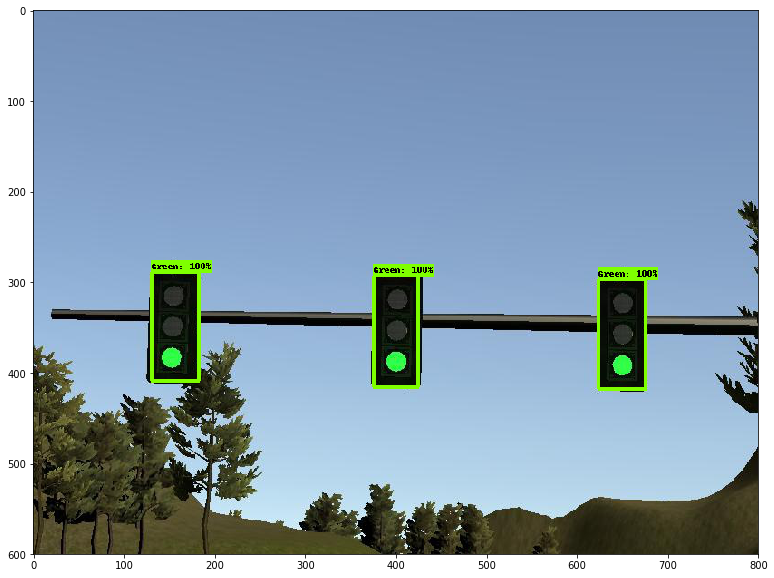

In [50]:
draw('../dataset-sdcnd-capstone/sim_training_data', annotated_samples[0])

## Create TFRecord
We know that TFRecord is well supported by [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection), so we create a script `create_tfrecord.py` to create TFRecord from our dataset. One can use the following command

```[bash]
# convert sim-data to TFRecord
python create_tfrecord.py --data_dir=dataset-sdcnd-capstone/sim_training_data \
    --label_map_path=./label_map.pbtxt --img_h=600 --img_w=800 \
    --output_path=sim.record
    
# convert real-data to TFRecord    
python create_tfrecord.py --data_dir=dataset-sdcnd-capstone/real_training_data \
    --label_map_path=./label_map.pbtxt --img_h=1096 --img_w=1368 \
    --output_path=real.record
```

## Fine-tune pretrained model
We follow the tutorial [pet detector](https://github.com/tensorflow/models/tree/master/research/object_detection), the required steps are

* download trained-model from [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)
* configure a object detection pipeline
* train (fine-tune) from the trained-model and test it with test data

We look at the following two models
* [ssd_inception_v2_coco](http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz)
* [faster_rcnn_resnet50_coco](http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz)

To train with `faster_rcnn_resnet50_coco`, we use the following command
```[bash]
python object_detection/legacy/train.py \
--pipeline_config_path=trained_models/config/faster_rcnn_resnet50_coco_carnd_sim.config \
--train_dir finetuned_models/faster_rcnn_resnet50_coco
```

## Export finetuned model for inference
Now we have a finetuned model, 

In [3]:
def import_graph(model_path):
    detection_graph = tf.Graph()
    
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
    
      with tf.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
    return detection_graph

In [11]:
def predict(detection_graph, image_paths):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            for image_path in image_paths:
                image = Image.open(image_path)
                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)

                time0 = time.time()

                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})

                time1 = time.time()

                boxes = np.squeeze(boxes)
                scores = np.squeeze(scores)
                classes = np.squeeze(classes).astype(np.int32)

                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np, boxes, classes, scores,
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=6)

                plt.figure(figsize=image_size)
                plt.imshow(image_np)
                plt.show()

                min_score_thresh = .50
                for i in range(boxes.shape[0]):
                    if scores is None or scores[i] > min_score_thresh:

                        class_name = category_index[classes[i]]['name']
                        print('{}'.format(class_name), scores[i])

                        fx =  0.97428
                        fy =  1.73205
                        perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                        perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                        # ymin, xmin, ymax, xmax = box
                        # depth_prime = (width_real * focal) / perceived_width
                        perceived_depth_x = ((.1 * fx) / perceived_width_x)
                        perceived_depth_y = ((.3 * fy) / perceived_width_y )

                        estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                        #print("Distance (metres)", estimated_distance)
                        #print("Time in milliseconds", (time1 - time0) * 1000, "\n")

In [5]:
detection_graph  = import_graph('../ssd_v2_frozem_sim/frozen_inference_graph.pb')

In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def load_test_images(directory):
    print(os.path.join(directory, '*.jpg'))
    image_paths = glob.glob(os.path.join(directory, '*.jpg'))
    print("Length of test images:", len(image_paths))
    return image_paths

In [7]:
image_paths = load_test_images("../media/tl_images/")

../media/tl_images/*.jpg
Length of test images: 20


In [8]:
label_map = label_map_util.load_labelmap('../label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=4, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Red'}, 2: {'id': 2, 'name': 'Yellow'}, 3: {'id': 3, 'name': 'Green'}, 4: {'id': 4, 'name': 'NoTrafficLight'}}


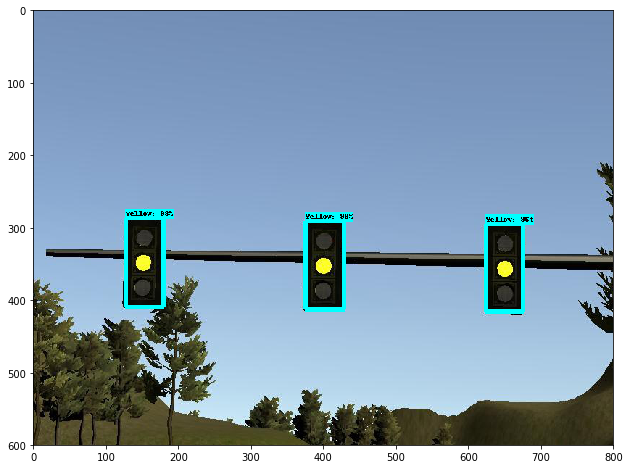

Yellow 0.98988533
Yellow 0.9869999
Yellow 0.9660857


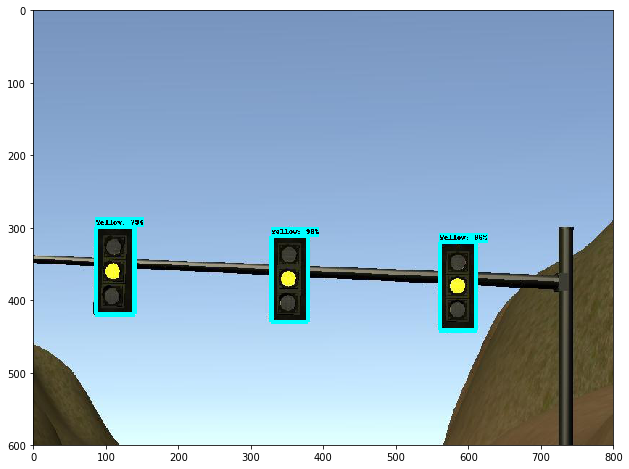

Yellow 0.98411167
Yellow 0.96716
Yellow 0.79111415


In [12]:
import time
image_size = (12, 8)

predict(detection_graph, image_paths[:2])

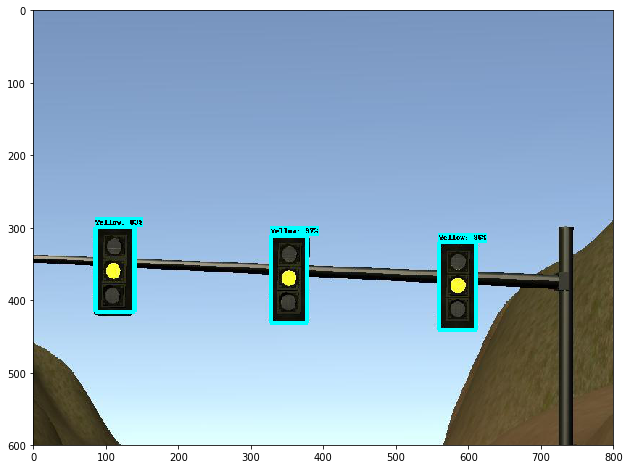

Yellow 0.97948956
Yellow 0.967842
Yellow 0.8358739


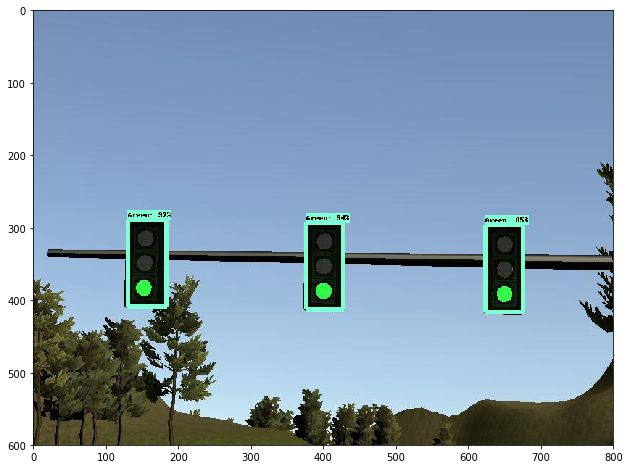

Green 0.9748239
Green 0.9427102
Green 0.85104436


In [13]:
predict(detection_graph, image_paths[2:4])